In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import adjusted_rand_score, silhouette_score
from utils import chart_ts

## Data processing

### Read data

In [79]:
df = pd.read_csv("all_coins_data.csv")
df.sort_values(["coin", "time"], inplace = True)
df = df[["time","daily_log_return", "coin"]]

### Min max Scaler

In [80]:
g = df.groupby(['coin'])["daily_log_return"]
min_, max_ = g.transform('min'), g.transform('max')
df['daily_log_return' + '_scale'] = (df['daily_log_return'] - min_) / (max_ - min_)
df

,time,daily_log_return,coin,daily_log_return_scale
0,2020-08-22,0.019340,ADA,0.448932
1,2020-08-23,-0.030797,ADA,0.345672
2,2020-08-24,0.017945,ADA,0.446059
3,2020-08-25,-0.094018,ADA,0.215463
4,2020-08-26,0.015859,ADA,0.441763
...,...,...,...,...
11065,2021-04-20,0.101394,ZEC,0.783696
11066,2021-04-21,-0.050885,ZEC,0.478312
11067,2021-04-22,-0.057575,ZEC,0.464897
11068,2021-04-23,-0.014870,ZEC,0.550537


In [81]:
df=df.pivot(index="time", columns="coin",values="daily_log_return_scale").reset_index()
df.head()

coins_list = df.columns.tolist()[1:]

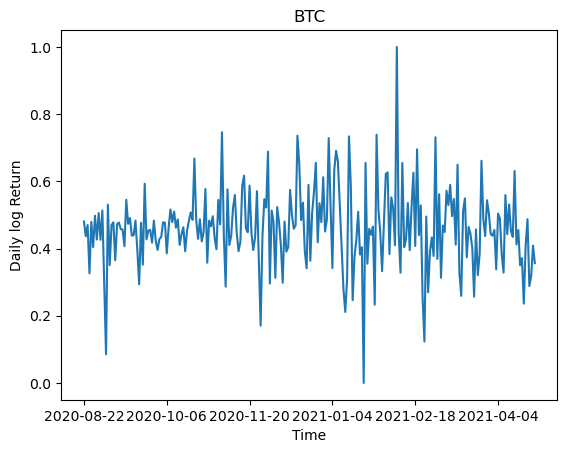

In [82]:
chart_ts(df, 6, coins_list)

## Max Adjusted Rand Score

In [83]:
max_ars = pd.DataFrame({"Cluster_number":[], "Adjusted Rand Score":[]})
for i in range(1, 10):
    data_array = np.array(df.T.drop('time').values)
    model = TimeSeriesKMeans(n_clusters=i, metric="dtw", max_iter=10)
    model.fit(data_array)
    coins = df.T.drop('time').index.tolist()
    y = model.predict(data_array)
    x = df.time
    max_ars.loc[len(max_ars.index)] = [i, adjusted_rand_score(df.drop("time", axis = 1).median(axis=0).values, y)]


/home/fede/anaconda3/envs/ts/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 45 1-dimensional timeseries
  warnings.warn(
/home/fede/anaconda3/envs/ts/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/fede/anaconda3/envs/ts/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 45 1-dimensional timeseries
  warnings.warn(
/home/fede/anaconda3/envs/ts/lib/python3.11/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/fede/anaconda3/envs/ts/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 

<Axes: xlabel='Cluster Number'>

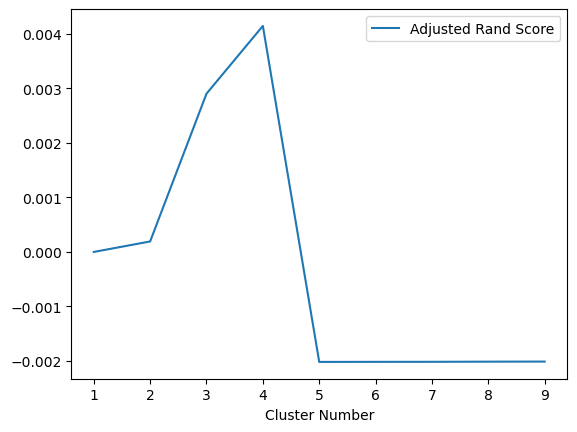

In [84]:
max_ars.rename(columns = {"Cluster_number":"Cluster Number"}).set_index("Cluster Number").plot()

### Clustering Model

In [88]:
data_array = np.array(df.T.drop('time').values)
model = TimeSeriesKMeans(n_clusters=4, metric="dtw", max_iter=10)
model.fit(data_array)
coins = df.T.drop('time').index.tolist()
y = model.predict(data_array)
x = df.time
clusters = pd.DataFrame({"coin":df.drop(["time"], axis = 1).columns.tolist(),
"cluster":y}).sort_values("cluster")

/home/fede/anaconda3/envs/ts/lib/python3.11/site-packages/tslearn/utils/utils.py:90: UserWarning: 2-Dimensional data passed. Assuming these are 45 1-dimensional timeseries
  warnings.warn(


<Axes: xlabel='cluster'>

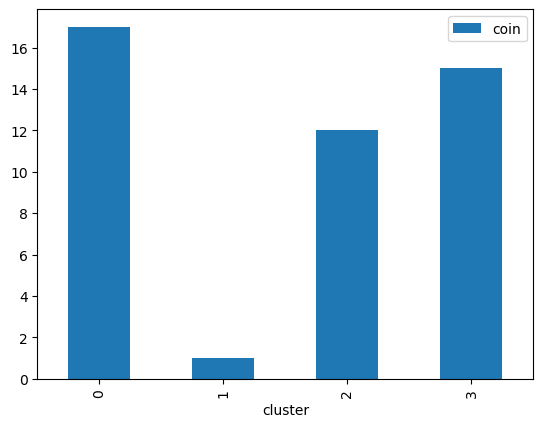

In [89]:
clusters.groupby("cluster").count().plot.bar()

### Plot Clusters

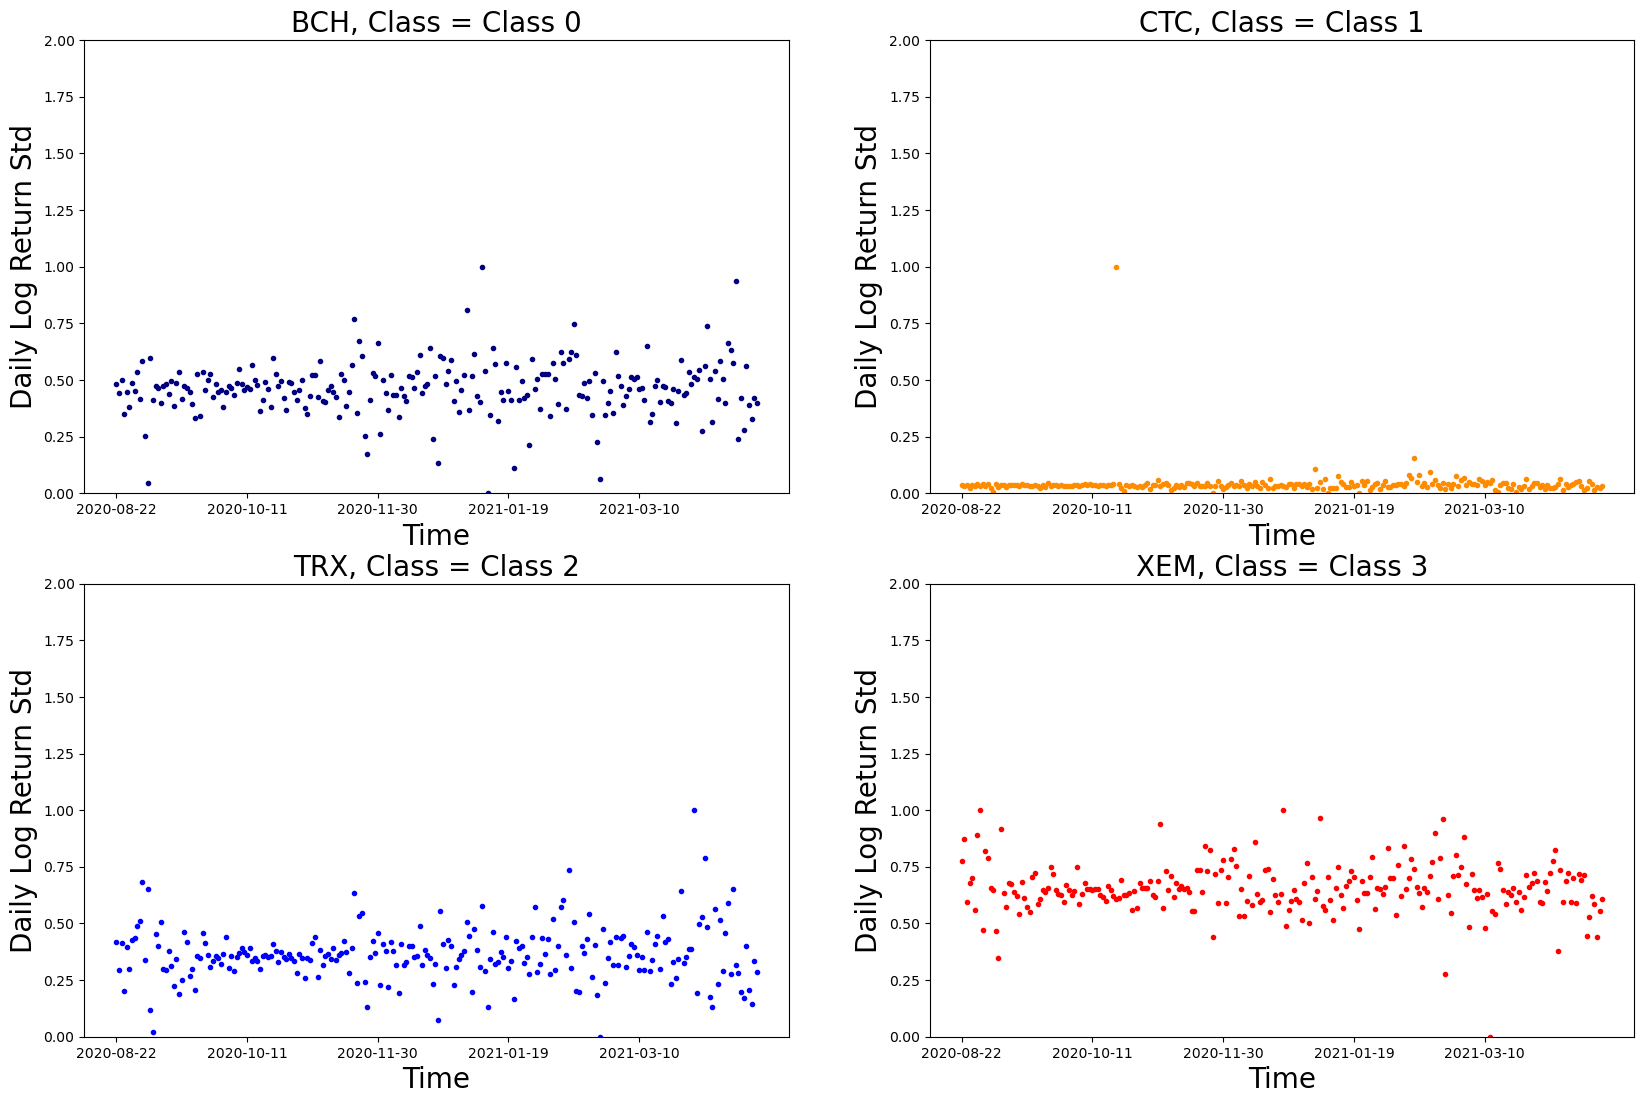

In [90]:
plt.figure(figsize=(20,20))
k_dict = {'1':0,'2':1,'3':2,'4':3}
colors = ['navy']*1+['darkorange']*1+['blue']*1+['red']*1
Names = ['Class 0']*1+['Class 1']*1+['Class 2']*1+['Class 3']*1
for j in range(1,5):
    plt.subplot(3,2,j)
    ax = plt.gca()
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(x,data_array[k],'.',color=colors[j-1])
    ax.set_xticks(ax.get_xticks()[::50])
    plt.ylabel('Std Daily Log Return',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('%s, Class = %s'%(coins_list[k],Names[j-1]),fontsize=20)
    plt.ylim(data_array.min(),2)